In [ ]:
pip install scikit-learn

In [1]:
import requests
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime,timedelta
from sklearn.metrics import accuracy_score
import pytz

In [2]:
API_KEY='a1b6f556b9085bf3baf738ea6566975c'
BASE_URL='https://api.openweathermap.org/data/2.5/'

1.Fetch Current_weather Data


In [3]:
def get_current_weather(city):
  url=f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
  response=requests.get(url)
  data=response.json()
  return{
      'city':data['name'],
      'current_temp':round(data['main']['temp']),
      'feels_like':round(data['main']['feels_like']),
      'temp_min':round(data['main']['temp_min']),
      'temp_max':round(data['main']['temp_max']),
      'humidity':round(data['main']['humidity']),
      'description':(data['weather'][0]['description']),
      'country':data['sys']['country'],
      'pressure':data['main']['pressure'],
      'wind_gust_dir':data['wind']['deg'],
      'Wind_Gust_Speed':data['wind']['speed']


   }

2.Read Historical Data


In [4]:
def read_historical_data(filename):
  df=pd.read_csv(filename)
  df=df.dropna()
  df=df.drop_duplicates()
  return df

prepare data for training

In [5]:
def prepare_data(data):
  le=LabelEncoder()
  data['WindGustDir']=le.fit_transform(data['WindGustDir'])
  data['RainTomorrow']=le.fit_transform(data['RainTomorrow'])

  x=data[['MinTemp','MaxTemp','WindGustDir','WindGustSpeed','Humidity','Pressure','Temp' ]]
  y=data['RainTomorrow']

  return x,y,le

Train Rain Prediction Model

In [6]:
def train_rain_model(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
  model=RandomForestClassifier(n_estimators=100,random_state=42)
  model.fit(x_train,y_train)


  y_pred=model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)


  print("mean_squared_error for rain model")

  print(mean_squared_error(y_test,y_pred))
  print(f"Rain Prediction Model Accuracy: {accuracy * 100:.2f}%")
  return model


prepare regression data

In [7]:

def prepare_regression_data(data,feature):
  x,y=[],[]

  for i in range(len(data)-1):
    x.append(data[feature].iloc[i])
    y.append(data[feature].iloc[i+1])
  x=np.array(x).reshape(-1,1)
  y=np.array(y)
  return x,y




Train Regression Model

In [8]:
def train_regression_model(x,y):
  model=RandomForestRegressor(n_estimators=100,random_state=42)
  model.fit(x,y)
  return model

predict future

In [9]:
def predict_future(model, current_value):
  predictions = [current_value]

  for _ in range(5):
    next_value = model.predict([[predictions[-1]]])
    predictions.append(next_value[0])
    return predictions[1:]


weather Analysis Function

Enter any city name: Mysore
Enter the year for prediction: 2050
mean_squared_error for rain model
0.1506849315068493
Rain Prediction Model Accuracy: 84.93%

mean_squared_error for rain model
0.030303030303030304
Rain Prediction Model Accuracy: 96.97%

Predicted Weather for Year 2050:
2026: Min 20.9C, Max 34.6C
2027: Min 16.6C, Max 31.2C
2028: Min 18.5C, Max 32.0C
2029: Min 17.2C, Max 32.3C
2030: Min 18.9C, Max 31.9C
2031: Min 18.5C, Max 31.6C
2032: Min 18.2C, Max 32.1C
2033: Min 18.3C, Max 29.8C
2034: Min 19.2C, Max 29.5C
2035: Min 16.5C, Max 30.0C
2036: Min 17.5C, Max 31.7C
2037: Min 16.6C, Max 30.6C
2038: Min 18.2C, Max 31.8C
2039: Min 18.3C, Max 31.3C
2040: Min 18.8C, Max 31.2C
2041: Min 18.3C, Max 30.1C
2042: Min 18.1C, Max 31.5C
2043: Min 17.8C, Max 29.7C
2044: Min 19.3C, Max 30.1C
2045: Min 18.0C, Max 30.7C
2046: Min 19.3C, Max 31.8C
2047: Min 16.6C, Max 31.4C
2048: Min 17.4C, Max 30.4C
2049: Min 18.8C, Max 31.3C
2050: Min 18.6C, Max 29.8C

Future Humidity Prediction:
2026: Min 4

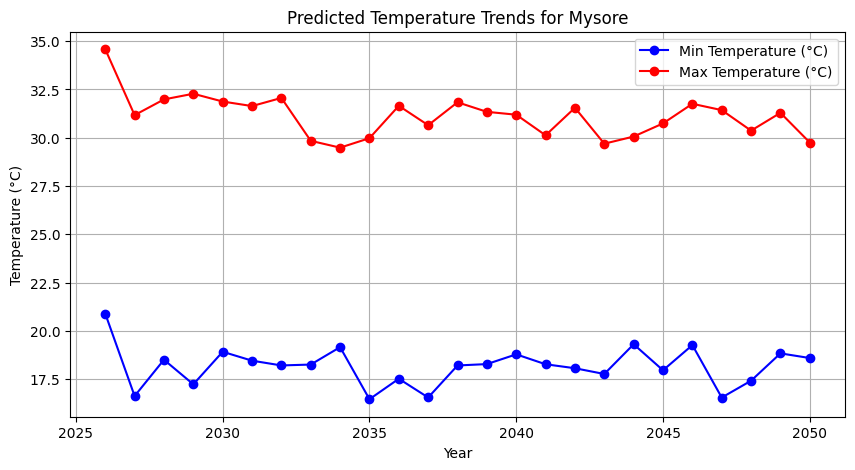

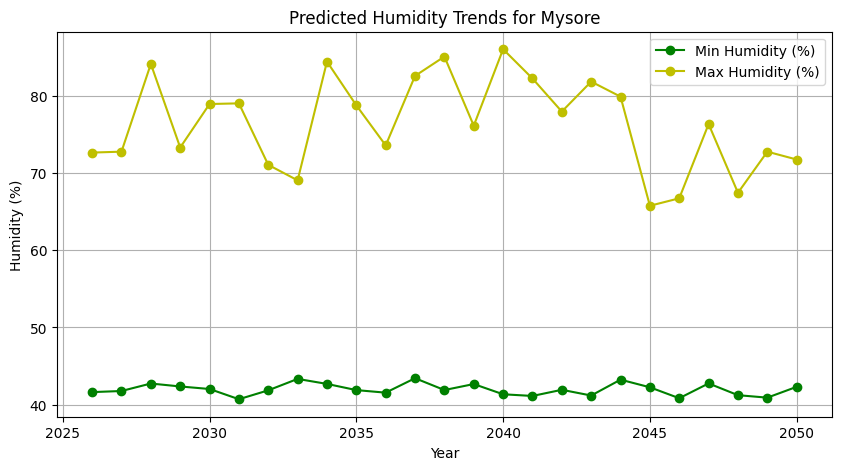

In [19]:


def predict_future(model, current_value, years=5, base_variation=5, extra_variation=3, is_humidity=False):
    """Predicts future values with realistic variations."""
    predictions = []
    last_value = current_value

    for _ in range(years):
        next_value = model.predict([[last_value]])[0]
        min_value = next_value - np.random.uniform(base_variation, base_variation + extra_variation)
        max_value = next_value + np.random.uniform(base_variation, base_variation + extra_variation)

        # Ensure realistic humidity range (no fixed upper limit)
        if is_humidity:
            min_value = max(0, min_value)  # Humidity cannot be negative
            max_value = min(100, max_value + np.random.uniform(10, 30))  # Allow natural increase

        predictions.append((min_value, max_value))
        last_value = next_value

    return predictions

def weather_view():
    city = input("Enter any city name: ")
    target_year = int(input("Enter the year for prediction: "))

    current_weather = get_current_weather(city)
    historical_data = read_historical_data('/content/weather (1).csv')

    x, y, le = prepare_data(historical_data)
    rain_model = train_rain_model(x, y)
    y_pred = rain_model.predict(x)
    mse = mean_squared_error(y, y_pred)
    accuracy = (1 - mse) * 100

    print(f"\nmean_squared_error for rain model\n{mse}")
    print(f"Rain Prediction Model Accuracy: {round(accuracy, 2)}%")

    x_temp, y_temp = prepare_regression_data(historical_data, 'Temp')
    x_hum, y_hum = prepare_regression_data(historical_data, 'Humidity')
    temp_model = train_regression_model(x_temp, y_temp)
    hum_model = train_regression_model(x_hum, y_hum)

    years_ahead = target_year - datetime.now().year
    future_temp = predict_future(temp_model, current_weather['current_temp'], years=years_ahead)
    future_humidity = predict_future(hum_model, current_weather['humidity'], years=years_ahead, is_humidity=True)

    years = list(range(datetime.now().year + 1, target_year + 1))
    min_temps, max_temps = zip(*future_temp)
    min_hums, max_hums = zip(*future_humidity)

    print(f"\nPredicted Weather for Year {target_year}:")
    for year, min_temp, max_temp in zip(years, min_temps, max_temps):
        print(f"{year}: Min {round(min_temp, 1)}C, Max {round(max_temp, 1)}C")

    print("\nFuture Humidity Prediction:")
    for year, min_hum, max_hum in zip(years, min_hums, max_hums):
        print(f"{year}: Min {round(min_hum, 1)}%, Max {round(max_hum, 1)}%")

    # Plot predictions
    plt.figure(figsize=(10, 5))
    plt.plot(years, min_temps, 'b-o', label="Min Temperature (°C)")
    plt.plot(years, max_temps, 'r-o', label="Max Temperature (°C)")
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Predicted Temperature Trends for {city}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(years, min_hums, 'g-o', label="Min Humidity (%)")
    plt.plot(years, max_hums, 'y-o', label="Max Humidity (%)")
    plt.xlabel("Year")
    plt.ylabel("Humidity (%)")
    plt.title(f"Predicted Humidity Trends for {city}")
    plt.legend()
    plt.grid(True)
    plt.show()

weather_view()





















